#Transformer applications: fake news detection#

In this notebook, I will build a classifier for fake news detection using one of the most popular transformer models, BERT.

The dataset that I will use is available here:
https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset/

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

There are two .csv files, one containing only fake news, the other one containing real news only.

In [4]:
import pandas as pd

fake_file_id = "1obGQj_9yLB88WtR5L9QbyJFB9RkB6kol"
true_file_id = "19sRgrqSRI7F7VGAuAFWQVAYBq5K35gJo"

fake_csv = "/content/drive/MyDrive/Fake.csv"
true_csv = "/content/drive/MyDrive/True.csv"

df_fake = pd.read_csv(fake_csv)
df_true = pd.read_csv(true_csv)

**Exploratory analysis**

Let's visualize them

In [5]:
df_fake

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"
...,...,...,...,...
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016"
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016"
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016"
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016"


In [6]:
df_true

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"
...,...,...,...,...
21412,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017"
21413,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017"
21414,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017"
21415,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017"


The two classes (real and fake) are more or less balanced, since we have 23k rows on one side and 21k rows on the other side. Now we concatenate them into a single dataset and we shuffle all the rows

In [7]:
df_fake['label'] = 0
df_true['label'] = 1

In [8]:
df_all = pd.concat([df_fake,df_true])
df = df_all.sample(frac = 1)

In [9]:
df

,title,text,subject,date,label
16756,HERE IT IS: List Of Democrat Hypocrites Who Vo...,"If you look closely, you might find a few fami...",Government News,"Feb 18, 2016",0
11235,Ted Cruz did not disclose 2012 Senate campaign...,(Reuters) - Republican presidential candidate ...,politicsNews,"January 14, 2016",1
18165,HILLARY’S PASTOR COMPARES Her Election Loss To...,"A United Methodist minister, Rev. Bill Shillad...",left-news,"Aug 11, 2017",0
9136,“NEVER-TRUMPER” and Weekly Standard Editor Sen...,The former Fox News contributor and editor of ...,politics,"Dec 22, 2017",0
4687,Trump Adviser Just Proved Hillary’s ‘Basket O...,"For some reason, the Trump campaign is utterly...",News,"September 10, 2016",0
...,...,...,...,...,...
18595,Pope wears refugee ID bracelet in appeal for h...,"BOLOGNA, Italy (Reuters) - Pope Francis on Sun...",worldnews,"October 1, 2017",1
19721,THREE THEORIES On Why FBI’s Comey Reopened Cli...,NBC reports:The FBI is reviewing a new batch o...,left-news,"Oct 29, 2016",0
3963,Trump says actively considering breaking up bi...,WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,"May 1, 2017",1
972,Trump says Manafort charges 'years ago'; indic...,WASHINGTON (Reuters) - President Donald Trump ...,politicsNews,"October 30, 2017",1


We will only keep the column "title" and the label:

In [10]:
news_texts = df['title'].tolist()
labels = df['label'].tolist()

So one news will look like this:

In [11]:
news_texts[0]

'HERE IT IS: List Of Democrat Hypocrites Who Voted To Filibuster GW Bush’s Final Supreme Court Pick'

Now we install the transformers library and download the BERT model

In [12]:
!pip install transformers

from sklearn.metrics import classification_report
from transformers import BertTokenizer, BertForSequenceClassification, AdamW


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 37.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 49.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 48.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 31.2 MB/s eta 0:00:00


In [13]:
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)  # 2 labels: 'true' and 'fake'

model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

**Training the model**

It's time to split the dataset into training, validation and test sets (we will do 80/10/10)

In [14]:
from sklearn.model_selection import train_test_split

# Split the dataset into training, validation, and test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(news_texts, labels, test_size=0.1, random_state=42)
train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, test_size=0.1, random_state=42)


Let's also visualize the histogram with the length of the news

Text(0, 0.5, 'Number of texts')

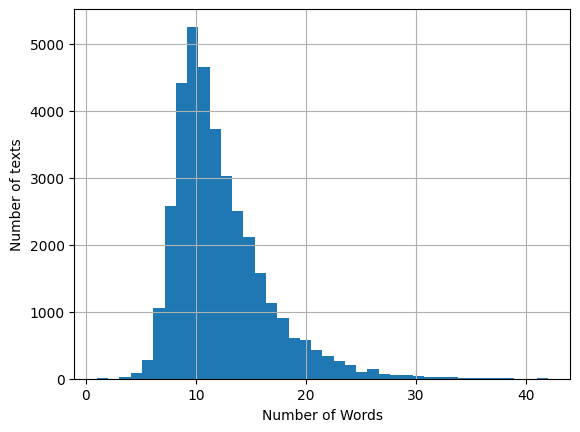

In [15]:
import matplotlib.pyplot as plt

# Plot histogram of the number of words in train data 'title'
seq_len = [len(title.split()) for title in train_texts]
pd.Series(seq_len).hist(bins = 40)
plt.xlabel('Number of Words')
plt.ylabel('Number of texts')

Now we need to tokenize the news

In [16]:
# Tokenize the news texts
train_encodings = tokenizer(train_texts, padding=True, truncation=True, return_tensors='pt')
val_encodings = tokenizer(val_texts, padding=True, truncation=True, return_tensors='pt')
test_encodings = tokenizer(test_texts, padding=True, truncation=True, return_tensors='pt')

train_encodings = {key: val.to(device) for key, val in train_encodings.items()}
val_encodings = {key: val.to(device) for key, val in val_encodings.items()}
test_encodings = {key: val.to(device) for key, val in test_encodings.items()}



And we create the three datasets (train, validation, test)

In [17]:
# Create PyTorch datasets
class NewsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], device=device)
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = NewsDataset(train_encodings, train_labels)
val_dataset = NewsDataset(val_encodings, val_labels)
test_dataset = NewsDataset(test_encodings, test_labels)

Finally, we define the data loaders, the optimizer and we start the training loop. We will only run 3 epochs to save time (the results will be more than satisfactory anyway)

In [18]:
# Define data loaders
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)


In [19]:
# Create an optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [20]:
# Training loop
num_epochs = 3  # Adjust the number of epochs as needed

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0.0
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    # Calculate average training loss for the epoch
    average_train_loss = total_train_loss / len(train_loader)

    # Validation loss calculation
    model.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']
            labels = batch['labels']
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_val_loss += loss.item()

    # Calculate average validation loss for the epoch
    average_val_loss = total_val_loss / len(val_loader)

    # Print training and validation loss for the epoch
    print(f'Epoch {epoch + 1} - Train Loss: {average_train_loss:.4f} - Validation Loss: {average_val_loss:.4f}')


Epoch 1 - Train Loss: 0.0792 - Validation Loss: 0.0322
Epoch 2 - Train Loss: 0.0244 - Validation Loss: 0.0332
Epoch 3 - Train Loss: 0.0120 - Validation Loss: 0.0429


The error on the validation set starts increasing, so it's good to stop here

**Evaluation of the model**

Now it's time to evaluate the performance of the model on the test dataset, which contains news that the model has not seen yet:

In [21]:
# Evaluation on the test set
model.eval()
predictions = []
true_labels = []

for batch in test_loader:
    with torch.no_grad():
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predicted_labels = torch.argmax(logits, dim=1)
        predictions.extend(predicted_labels.tolist())
        true_labels.extend(labels.tolist())

In [22]:
# Generate a classification report
target_names = ['real', 'fake']
report = classification_report(true_labels, predictions, target_names=target_names)
print(report)


              precision    recall  f1-score   support

        real       0.99      0.99      0.99      2359
        fake       0.99      0.99      0.99      2131

    accuracy                           0.99      4490
   macro avg       0.99      0.99      0.99      4490
weighted avg       0.99      0.99      0.99      4490



The model achieves 99% precision and recall on both category, quite good.

We can test it on a few news - first we define a function that returns the label and its corresponding probability:

In [28]:
# Define a function for prediction
def predict_news_authenticity(news_text):
    # Tokenize the news text
    inputs = tokenizer(news_text,padding=True, truncation=True, return_tensors='pt').to(device)

    # Make a prediction
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    # Convert logits to probabilities and determine the class
    probabilities = torch.softmax(logits, dim=1)
    predicted_class = torch.argmax(probabilities, dim=1).item()

    # Map the class to 'real' or 'fake'
    class_labels = ['fake','real']
    predicted_label = class_labels[predicted_class]

    return predicted_label, probabilities



And now we use it on a few news from the test dataset:

In [29]:
news_text = test_texts[0]
predicted_label, probabilities = predict_news_authenticity(news_text)
print(f"News: {news_text}")
print(f"Predicted Label: {predicted_label}")
print(f"Class Probabilities (Real, Fake): {probabilities.tolist()[0]}")

News: On Trump travel ban, China says 'reasonable concerns' must be considered
Predicted Label: real
Class Probabilities (Real, Fake): [8.795961184659973e-05, 0.9999120235443115]


In [30]:
news_text = test_texts[1]
predicted_label, probabilities = predict_news_authenticity(news_text)
print(f"News: {news_text}")
print(f"Predicted Label: {predicted_label}")
print(f"Class Probabilities (Real, Fake): {probabilities.tolist()[0]}")

News: Kurds abandon territory in the face of Iraq government advance
Predicted Label: real
Class Probabilities (Real, Fake): [0.00013333861716091633, 0.9998666048049927]


In [32]:
news_text = test_texts[2]
predicted_label, probabilities = predict_news_authenticity(news_text)
print(f"News: {news_text}")
print(f"Predicted Label: {predicted_label}")
print(f"Class Probabilities (Real, Fake): {probabilities.tolist()[0]}")

News: WHAT? OUR CIA DIRECTOR Just Admitted To An “Indiscretion” That’s Mind Boggling…How Did This Guy Become CIA Director?
Predicted Label: fake
Class Probabilities (Real, Fake): [0.9999349117279053, 6.506284262286499e-05]


In [33]:
news_text = test_texts[3]
predicted_label, probabilities = predict_news_authenticity(news_text)
print(f"News: {news_text}")
print(f"Predicted Label: {predicted_label}")
print(f"Class Probabilities (Real, Fake): {probabilities.tolist()[0]}")

News: Indonesia says 40,000 evacuated from Bali volcano, more need to move
Predicted Label: real
Class Probabilities (Real, Fake): [0.00012004531890852377, 0.9998799562454224]


In [34]:
news_text = test_texts[4]
predicted_label, probabilities = predict_news_authenticity(news_text)
print(f"News: {news_text}")
print(f"Predicted Label: {predicted_label}")
print(f"Class Probabilities (Real, Fake): {probabilities.tolist()[0]}")

News: Failure of German coalition talks would strengthen populists: EU's Oettinger
Predicted Label: real
Class Probabilities (Real, Fake): [8.655624696984887e-05, 0.9999134540557861]


All good, the model correctly predicts real/fake news with high confidence. These were all examples taken from our test dataset. What about using fake news taken from the internet? Let's see by using some ridicoulous ones:

In [35]:
news_text = "Pope Francis shocks world, endorses Donald Trump for President, releases statement"
predicted_label, probabilities = predict_news_authenticity(news_text)
print(f"News: {news_text}")
print(f"Predicted Label: {predicted_label}")
print(f"Class Probabilities (Real, Fake): {probabilities.tolist()[0]}")

News: Pope Francis shocks world, endorses Donald Trump for President, releases statement
Predicted Label: fake
Class Probabilities (Real, Fake): [0.9924747347831726, 0.007525303866714239]


In [38]:
news_text = "Texas man admits kidnapping 79 people to anally probe them while disguised as an alien"
predicted_label, probabilities = predict_news_authenticity(news_text)
print(f"News: {news_text}")
print(f"Predicted Label: {predicted_label}")
print(f"Class Probabilities (Real, Fake): {probabilities.tolist()[0]}")

News: Texas man admits kidnapping 79 people to anally probe them while disguised as an alien
Predicted Label: fake
Class Probabilities (Real, Fake): [0.9676023125648499, 0.032397668808698654]


In [39]:
news_text = "Military Sentences Liz Cheney to Hang to Death"
predicted_label, probabilities = predict_news_authenticity(news_text)
print(f"News: {news_text}")
print(f"Predicted Label: {predicted_label}")
print(f"Class Probabilities (Real, Fake): {probabilities.tolist()[0]}")

News: Military Sentences Liz Cheney to Hang to Death
Predicted Label: fake
Class Probabilities (Real, Fake): [0.9830081462860107, 0.016991887241601944]


In [40]:
news_text = "Kentucky man threws a boomerang and hit himself in the head, and wins a $300,000 lawsuit against himself"
predicted_label, probabilities = predict_news_authenticity(news_text)
print(f"News: {news_text}")
print(f"Predicted Label: {predicted_label}")
print(f"Class Probabilities (Real, Fake): {probabilities.tolist()[0]}")


News: Kentucky man threws a boomerang and hit himself in the head, and wins a $300,000 lawsuit against himself
Predicted Label: fake
Class Probabilities (Real, Fake): [0.9993334412574768, 0.000666590582113713]


The model correctly labels all of them as fake news. What about if we use some real news from these days?

In [42]:
news_text = "White Island: Company found guilty over New Zealand volcano disaster"
predicted_label, probabilities = predict_news_authenticity(news_text)
print(f"News: {news_text}")
print(f"Predicted Label: {predicted_label}")
print(f"Class Probabilities (Real, Fake): {probabilities.tolist()[0]}")

News: White Island: Company found guilty over New Zealand volcano disaster
Predicted Label: real
Class Probabilities (Real, Fake): [0.0001324313780060038, 0.9998675584793091]


In [43]:
news_text = "Argentina captain Lionel Messi won a record eighth Ballon d'Or for the best player in the world on Monday"
predicted_label, probabilities = predict_news_authenticity(news_text)
print(f"News: {news_text}")
print(f"Predicted Label: {predicted_label}")
print(f"Class Probabilities (Real, Fake): {probabilities.tolist()[0]}")

News: Argentina captain Lionel Messi won a record eighth Ballon d'Or for the best player in the world on Monday
Predicted Label: real
Class Probabilities (Real, Fake): [0.3962365388870239, 0.6037635207176208]


In [45]:
news_text = "Dozens of people are reported killed after a blast at the Jabalia refugee camp in northern Gaza"
predicted_label, probabilities = predict_news_authenticity(news_text)
print(f"News: {news_text}")
print(f"Predicted Label: {predicted_label}")
print(f"Class Probabilities (Real, Fake): {probabilities.tolist()[0]}")

News: Dozens of people are reported killed after a blast at the Jabalia refugee camp in northern Gaza
Predicted Label: real
Class Probabilities (Real, Fake): [0.12622693181037903, 0.8737730979919434]


The model correctly labels them as real news. It seems to work quite well